In [1]:
import os
import pathlib
import random
import functools
import copy
import sys
import pickle
import tarfile
import operator
import math
import requests
import importlib
import time

import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn import preprocessing
import scipy

import tensorflow as tf
import tensorflow_datasets as tfds

import jax
import jax.numpy as jnp
from jax.experimental import optimizers
jax.config.update("jax_enable_x64", True)

import flax

import neural_tangents as nt

import vit_jax

import adversarial_ntks as atk

In [2]:
key = jax.random.PRNGKey(0)

In [3]:
CIFAR10 = {
    "train": atk.dataset.get_np_data(
        name="cifar10", split="train", flatten=False, data_dir=".data/"),
    "test": atk.dataset.get_np_data(
        name="cifar10", split="test[:2000]", flatten=False, data_dir=".data/"),
    "channels": 3,
    "labels": ["airplane", "automobile", "bird", "cat", "deer",
        "dog", "frog", "horse", "ship", "truck"],
    
    "batch_size": 1000,
    "step_size": 1e-3,
    
    "num_epochs": 10
}
CIFAR10["num_classes"] = len(CIFAR10["labels"])
CIFAR10["opt_init"], CIFAR10["opt_update"], CIFAR10["get_params"] = \
    optimizers.adam(CIFAR10["step_size"])

In [4]:
CIFAR10["init_fun"], CIFAR10["conv_net"] = jax.experimental.stax.serial(
    jax.experimental.stax.Conv(64, (5, 5), (2, 2), padding="SAME"),
    jax.experimental.stax.BatchNorm(), jax.experimental.stax.Relu,
    jax.experimental.stax.Conv(64, (5, 5), (2, 2), padding="SAME"),
    jax.experimental.stax.BatchNorm(), jax.experimental.stax.Relu,
    jax.experimental.stax.MaxPool((2, 2)),
    jax.experimental.stax.Conv(64, (3, 3), (2, 2), padding="SAME"),
    jax.experimental.stax.BatchNorm(), jax.experimental.stax.Relu,
    jax.experimental.stax.Conv(64, (3, 3), (2, 2), padding="SAME"),
    jax.experimental.stax.BatchNorm(), jax.experimental.stax.Relu,
    jax.experimental.stax.MaxPool((2, 2)),
    jax.experimental.stax.Conv(64, (3, 3), (2, 2), padding="SAME"), jax.experimental.stax.Relu,
    jax.experimental.stax.Flatten,
    jax.experimental.stax.Dense(CIFAR10["num_classes"]),
    jax.experimental.stax.LogSoftmax)

_, CIFAR10["params"] = CIFAR10["init_fun"](key, (CIFAR10["batch_size"], 32, 32, 3))

In [5]:
def accuracy(params):
    """ Compute the accuracy for the CNN case (no flattening of input)"""
    acc_total = 0
    for step in range(len(CIFAR10["test"][0]) // CIFAR10["batch_size"]):
        images = CIFAR10["test"][0][step * CIFAR10["batch_size"]:(step + 1) * CIFAR10["batch_size"]]
        target_class = CIFAR10["test"][1][step * CIFAR10["batch_size"]:(step + 1) * CIFAR10["batch_size"]]

        predicted_class = np.argmax(CIFAR10["conv_net"](params, images), axis=1)
        acc_total += np.sum(predicted_class == target_class)
    return acc_total/len(CIFAR10["test"][0])

def accuracy_train(params):
    """ Compute the accuracy for the CNN case (no flattening of input)"""
    acc_total = 0
    for step in range(len(CIFAR10["train"][0]) // CIFAR10["batch_size"]):
        images = CIFAR10["train"][0][step * CIFAR10["batch_size"]:(step + 1) * CIFAR10["batch_size"]]
        target_class = CIFAR10["train"][1][step * CIFAR10["batch_size"]:(step + 1) * CIFAR10["batch_size"]]

        predicted_class = np.argmax(CIFAR10["conv_net"](params, images), axis=1)
        acc_total += np.sum(predicted_class == target_class)
    return acc_total/len(CIFAR10["train"][0])

def loss(params, images, targets):
    preds = CIFAR10["conv_net"](params, images)
    return -np.sum(preds * targets)

def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = jax.value_and_grad(loss)(params, x, y)
    opt_state = CIFAR10["opt_update"](0, grads, opt_state)
    return CIFAR10["get_params"](opt_state), opt_state, value

In [6]:
def run_training_loop(num_epochs, opt_state):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    CIFAR10["params"] = CIFAR10["get_params"](opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy_train(CIFAR10["params"])
    test_acc = accuracy(CIFAR10["params"])
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        for step in tqdm.tqdm(range(len(CIFAR10["train"][0]) // CIFAR10["batch_size"])):
            x = CIFAR10["train"][0][step * CIFAR10["batch_size"]:(step + 1) * CIFAR10["batch_size"]]
            y = CIFAR10["train"][1][step * CIFAR10["batch_size"]:(step + 1) * CIFAR10["batch_size"]]
            CIFAR10["params"], opt_state, loss = update(CIFAR10["params"], x, np.array([
                [1 if a == label else 0 for a in range(CIFAR10["num_classes"])]
                for label in y
            ]), opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        train_acc = accuracy_train(CIFAR10["params"])
        test_acc = accuracy(CIFAR10["params"])
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | T: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))

    return train_loss, log_acc_train, log_acc_test

In [7]:
CIFAR10["opt_state"] = CIFAR10["opt_init"](CIFAR10["params"])

train_loss, train_log, test_log = run_training_loop(CIFAR10["num_epochs"],
      CIFAR10["opt_state"])

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 | T: 30.47 | Train A: 0.553 | Test A: 0.547


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2 | T: 21.60 | Train A: 0.640 | Test A: 0.622


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3 | T: 21.00 | Train A: 0.688 | Test A: 0.653


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4 | T: 20.02 | Train A: 0.724 | Test A: 0.670


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5 | T: 19.00 | Train A: 0.750 | Test A: 0.678


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6 | T: 18.86 | Train A: 0.776 | Test A: 0.682


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7 | T: 20.89 | Train A: 0.791 | Test A: 0.688


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8 | T: 18.81 | Train A: 0.804 | Test A: 0.689


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9 | T: 19.27 | Train A: 0.817 | Test A: 0.684


100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


Epoch 10 | T: 19.38 | Train A: 0.834 | Test A: 0.701


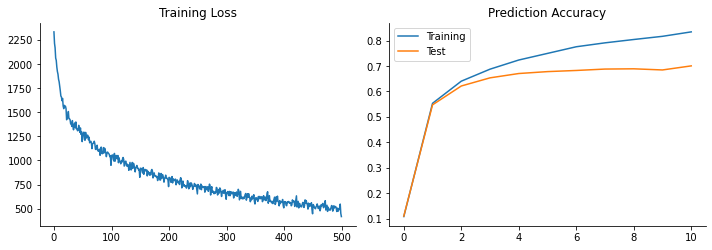

In [8]:
def plt_stats(train_loss, train_acc, test_acc):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot(train_loss)
    axs[0].set_title("Training Loss")

    axs[1].plot(train_acc, label="Training")
    axs[1].plot(test_acc, label="Test")
    axs[1].set_title("Prediction Accuracy")
    axs[1].legend()

    # Give data more room to bloom!
    for i in range(2):
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)

    fig.tight_layout(rect=[0, 0.03, 1, 0.925])

plt_stats(train_loss, train_log, test_log)

In [9]:
with open(".data/vit-pgd-cifar10.perturbed", "rb") as file:
    CIFAR10["perturbed"] = pickle.load(file)
print(CIFAR10["perturbed"].shape)

(2000, 32, 32, 3)


0.6535
Correct labels: ['horse', 'airplane', 'frog', 'truck', 'dog', 'automobile', 'horse', 'airplane', 'cat', 'bird']


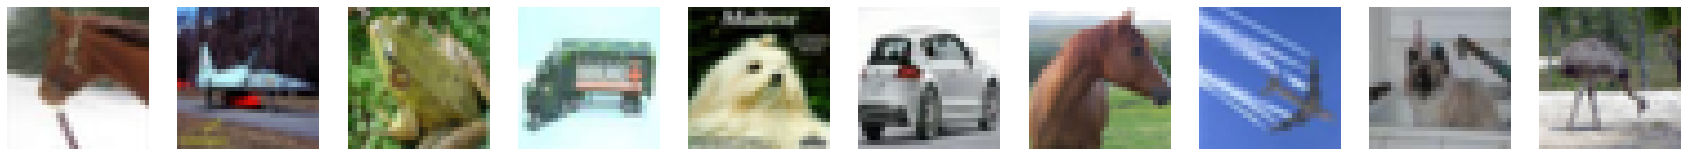

Predicted labels: ['horse', 'airplane', 'frog', 'truck', 'cat', 'automobile', 'horse', 'airplane', 'dog', 'deer']


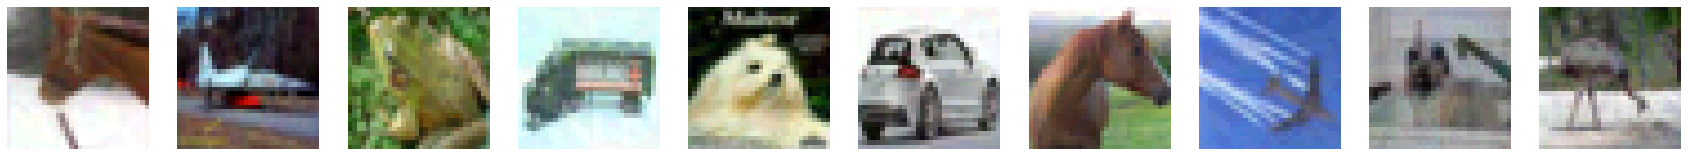

Perturbed labels: ['horse', 'airplane', 'frog', 'truck', 'dog', 'automobile', 'horse', 'airplane', 'bird', 'deer']


In [10]:
def accuracy_2(params):
    """ Compute the accuracy for the CNN case (no flattening of input)"""
    acc_total = 0
    for step in range(len(CIFAR10["perturbed"]) // CIFAR10["batch_size"]):
        images = CIFAR10["perturbed"][step * CIFAR10["batch_size"]:(step + 1) * CIFAR10["batch_size"]].astype(np.float32)
        target_class = CIFAR10["test"][1][step * CIFAR10["batch_size"]:(step + 1) * CIFAR10["batch_size"]]

        predicted_class = np.argmax(CIFAR10["conv_net"](params, images), axis=1)
        acc_total += np.sum(predicted_class == target_class)
    return acc_total/len(CIFAR10["test"][0])
print(accuracy_2(CIFAR10["params"]))
print("Correct labels:", [CIFAR10["labels"][a]
    for a in CIFAR10["test"][1][:10]])
plt.figure(figsize=(30, 3))
atk.dataset.plot_sample_data(CIFAR10["test"][0][:10], flat=False, channels=3)
predictions = np.argmax(CIFAR10["conv_net"](CIFAR10["params"], CIFAR10["test"][0][:CIFAR10["batch_size"]]), axis=1)
print("Predicted labels:", [CIFAR10["labels"][a]
    for a in predictions[:10]])
plt.figure(figsize=(30, 3))
atk.dataset.plot_sample_data(CIFAR10["perturbed"][:10], flat=False, channels=3)
perturbed_labels = np.argmax(CIFAR10["conv_net"](CIFAR10["params"],
    CIFAR10["perturbed"][:CIFAR10["batch_size"]].astype(np.float32)), axis=1)
print("Perturbed labels:", [CIFAR10["labels"][a]
    for a in perturbed_labels[:10]])